In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

# from utils import get_annotator_biases, get_texts_entropy, get_texts_std

from scipy.stats import entropy
from tqdm import tqdm
from typing import List, Callable

In [2]:
data_dir = Path('..') / '..' / '..' / 'storage' / 'doccano' / '2023_ecai_nlperspectives'

annotations_path = data_dir / 'data_with_min_20_annotations' / 'annotations.csv'
texts_path = data_dir / 'data_with_min_20_annotations' / 'data.csv'
questionnaire_path = data_dir / 'questionnaire_data' / 'HumaNLP_kwestionariusze.csv'
user_bias_path = data_dir / 'metrics' / 'user_bias.csv'

visualizations_dir = Path('visualizations')

annotations_df = pd.read_csv(annotations_path, 
                             sep=',', 
                             dtype={'text_id': np.int32, 'user_id': np.int32, 'Pozytywne': np.int32, 'Negatywne': np.int32, 'Radość': np.int32, 
                                    'Zachwyt': np.int32, 'Inspiruje': np.int32, 'Spokój': np.int32, 'Zaskoczenie': np.int32, 'Współczucie': np.int32, 
                                    'Strach': np.int32, 'Smutek': np.int32, 'Wstręt': np.int32, 'Złość': np.int32, 'Ironiczny': np.int32, 
                                    'Żenujący': np.int32, 'Wulgarny': np.int32, 'Polityczny': np.int32, 'Interesujący': np.int32, 
                                    'Zrozumiały': np.int32, 'Zgadzam się z tekstem': np.int32, 'Wierzę w tę informację': np.int32, 
                                    'Potrzebuję więcej informacji, aby ocenić ten tekst': np.int32, 'Czuję sympatię do autora': np.int32, 
                                    'Obraża mnie': np.int32, 'Może kogoś atakować / obrażać / lekceważyć': np.int32, 'Mnie bawi/śmieszy?': np.int32, 
                                    'Może kogoś bawić?': np.int32})

texts_df = pd.read_csv(texts_path, sep=',', dtype={'text_id': np.int32, 'text': str})

questionnaire_df = pd.read_csv(questionnaire_path, sep=';')

user_bias_df = pd.read_csv(user_bias_path, sep=',')

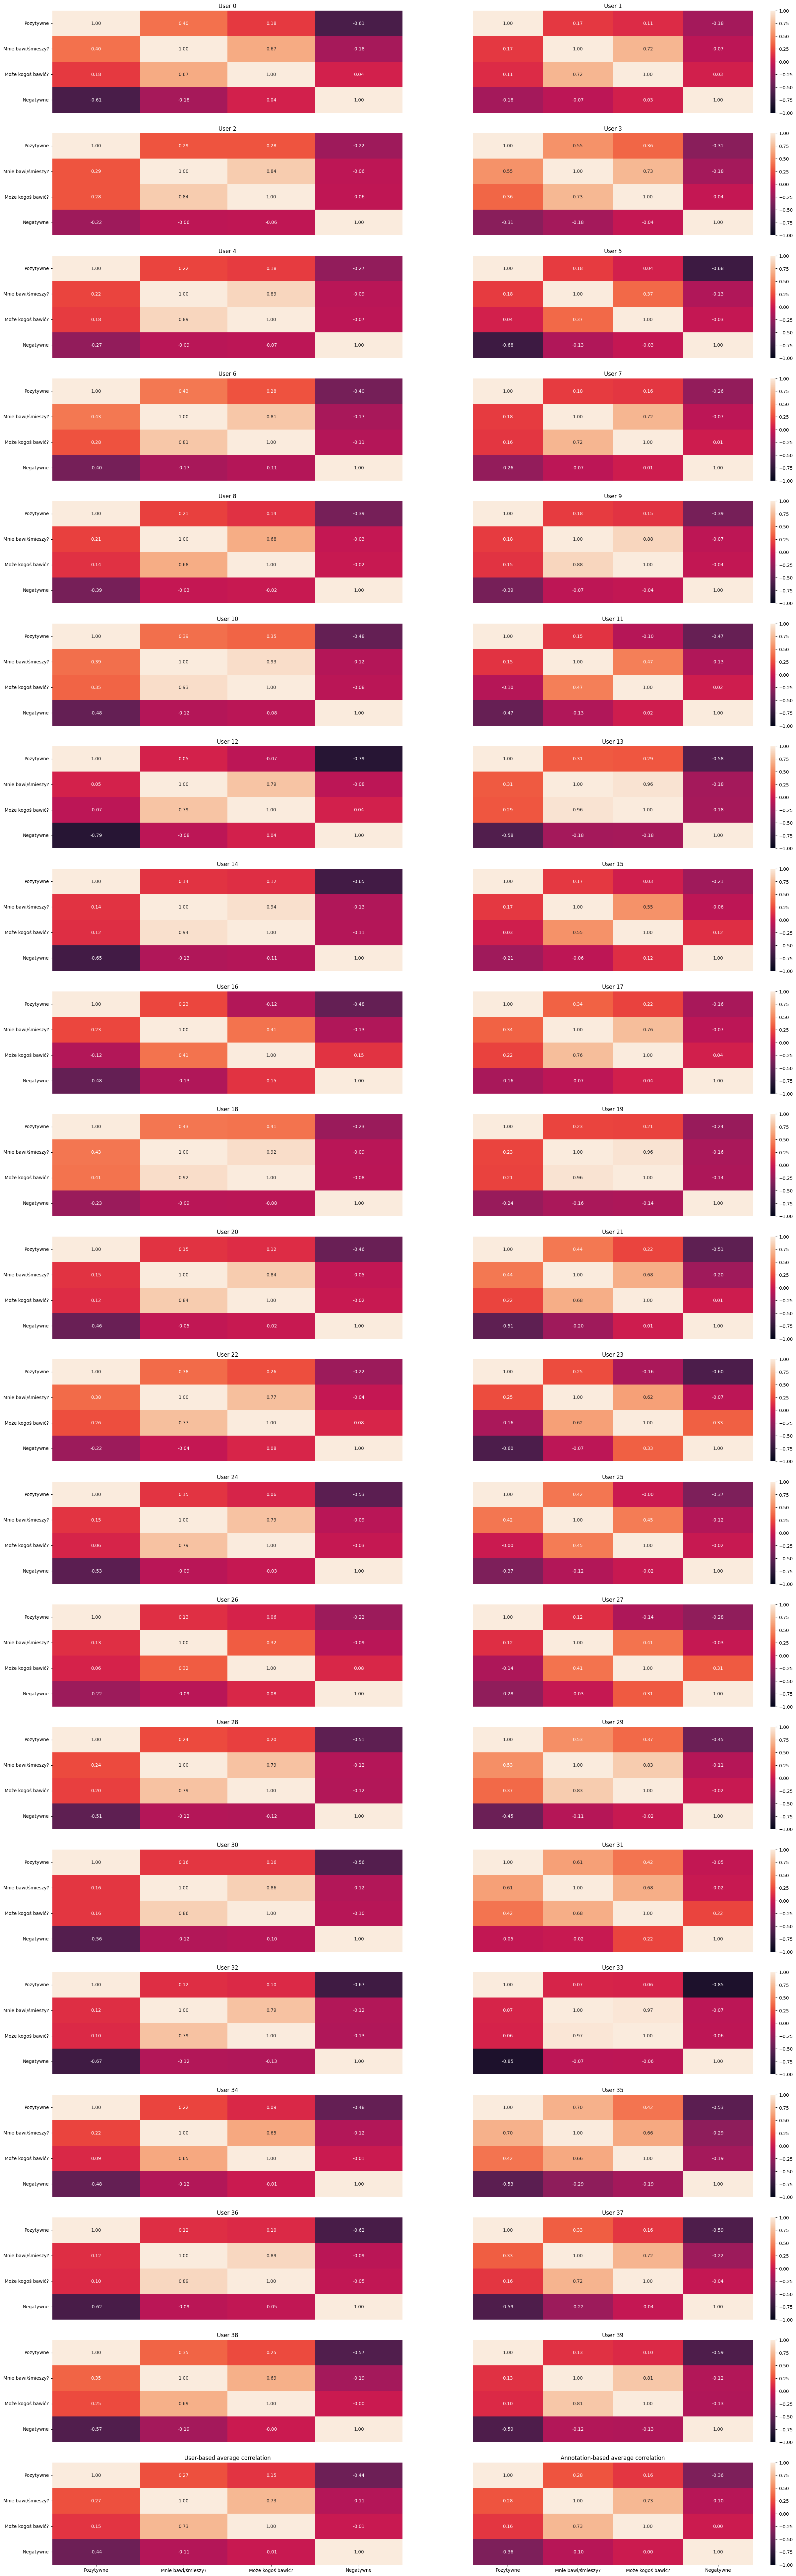

In [4]:
# humor-related user bias columns
bias_columns = ['Pozytywne_bias', 'Mnie bawi/śmieszy?_bias', 'Może kogoś bawić?_bias', 'Negatywne_bias', 'mean_bias']

# humor-related annotations columns
annotations_columns = ['Pozytywne', 'Mnie bawi/śmieszy?', 'Może kogoś bawić?', 'Negatywne']

# users ommited during creation of user-aggregated heatmap
not_aggregated_users = []

# copy Dataframe from previously downloaded file
df = annotations_df.copy()

# leave only those text, where at least one annotation for each task is not a zero
avg_df = df.groupby('text_id').mean(numeric_only=True)
nonzero_avg_texts = avg_df[(avg_df[annotations_columns] > 0).all(axis=1)].index.tolist()
df = df[df['text_id'].isin(nonzero_avg_texts)]

# create new dataframe with specific columns
task_df = df[annotations_columns]
df_list = [df[df['user_id'] == user_id][annotations_columns] for user_id in range(40)]
corr_list = [df.corr() for df in df_list]

vmin = min(corr.values.min() for corr in corr_list)
vmax = max(corr.values.max() for corr in corr_list)

fig, axs = plt.subplots(ncols=2, nrows=21, figsize=(30, 100))
        
for row_idx in range(21):
        for col_idx in range(2):
                xticklabels = False if row_idx < 20 else corr.columns
                yticklabels = corr_list[0].columns if col_idx == 0 else False
                cbar = col_idx == 1

                if row_idx < 20:
                        # calculate the correlation matrix
                        corr = corr_list[row_idx * 2 + col_idx]
                        axs[row_idx, col_idx].set_title(f'User {row_idx * 2 + col_idx}')

                elif col_idx == 0:
                        # calculate user-grouped average correlation matrix
                        corr_list_temp = [df_corr for i, df_corr in enumerate(corr_list) if i not in not_aggregated_users]
                        corr = sum(corr_list_temp) / len(corr_list_temp)
                        axs[row_idx, col_idx].set_title('User-based average correlation')

                elif col_idx == 1:
                        # calculate general average correlation matrix
                        corr = task_df.corr()
                        axs[row_idx, col_idx].set_title('Annotation-based average correlation')

                sns.heatmap(corr, 
                        annot=True, 
                        ax=axs[row_idx, col_idx], 
                        xticklabels=xticklabels, 
                        yticklabels=yticklabels,
                        cbar=cbar,
                        # vmin=vmin,
                        # vmax=vmax,
                        fmt='.2f',
                        vmin=-1, 
                        vmax=1)   
                             
plt.yticks(rotation=0)

if not os.path.exists(visualizations_dir):
    os.mkdir(visualizations_dir)

plt.savefig(visualizations_dir / 'doccano_text_corr_users_humor_polar.pdf', dpi=300)

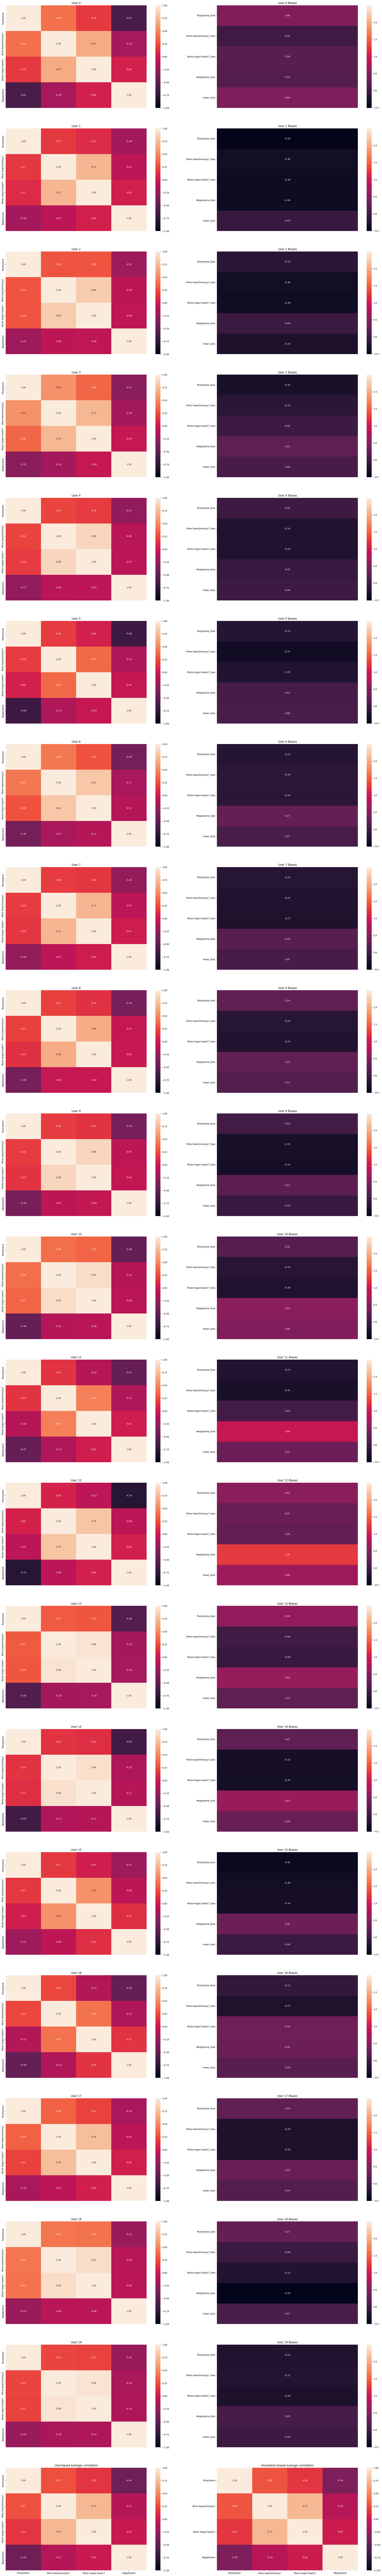

In [9]:
# humor-related user bias columns
bias_columns = ['Pozytywne_bias', 'Mnie bawi/śmieszy?_bias', 'Może kogoś bawić?_bias', 'Negatywne_bias', 'mean_bias']

# humor-related annotations columns
annotations_columns = ['Pozytywne', 'Mnie bawi/śmieszy?', 'Może kogoś bawić?', 'Negatywne']

# users ommited during creation of user-aggregated heatmap
not_aggregated_users = []

# copy Dataframe from previously downloaded file
df = annotations_df.copy()

# leave only those text, where at least one annotation for each task is not a zero
avg_df = df.groupby('text_id').mean(numeric_only=True)
nonzero_avg_texts = avg_df[(avg_df[annotations_columns] > 0).all(axis=1)].index.tolist()
df = df[df['text_id'].isin(nonzero_avg_texts)]

# create new dataframe with specific columns
task_df = df[annotations_columns]
df_list = [df[df['user_id'] == user_id][annotations_columns] for user_id in range(40)]
corr_list = [df.corr() for df in df_list]

# create list with user bias values
user_bias_list = [np.asarray(user_bias_df[user_bias_df['user_id'] == user_id][bias_columns].values.tolist()).reshape(-1, 1) for user_id in range(40)]

vmin = min(corr.values.min() for corr in corr_list)
vmax = max(corr.values.max() for corr in corr_list)

fig, axs = plt.subplots(ncols=2, nrows=21, figsize=(30, 200))
        
for row_idx in range(21):
        for col_idx in range(2):
                yticklabels = bias_columns if col_idx == 1 and row_idx < 20 else corr_list[0].columns
                # cbar = col_idx == 1
                cbar = True

                if row_idx < 20:
                        if col_idx == 0:
                                # calculate the correlation matrix
                                vmin = -1
                                vmax = 1
                                corr = corr_list[row_idx]
                                xticklabels = False
                                axs[row_idx, col_idx].set_title(f'User {row_idx}')
                        if col_idx == 1:
                                # get user bias values
                                # corr = np.asarray(user_bias_df[user_bias_df['user_id'] == row_idx][bias_columns].values).reshape(-1, 1)
                                corr = user_bias_list[row_idx]
                                vmin = min(min(bias_list) for bias_list in user_bias_list)
                                vmax = max(max(bias_list) for bias_list in user_bias_list)
                                # print(corr)
                                xticklabels = False 
                                axs[row_idx, col_idx].set_title(f'User {row_idx} Biases')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                elif row_idx == 20:
                        xticklabels = annotations_columns
                        vmin = -1
                        vmax = 1
                        if col_idx == 0:
                                # calculate user-grouped average correlation matrix
                                corr_list_temp = [df_corr for i, df_corr in enumerate(corr_list) if i not in not_aggregated_users]
                                corr = sum(corr_list_temp) / len(corr_list_temp)
                                axs[row_idx, col_idx].set_title('User-based average correlation')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                        elif col_idx == 1:
                                # calculate general average correlation matrix
                                corr = task_df.corr()
                                axs[row_idx, col_idx].set_title('Annotation-based average correlation')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                sns.heatmap(corr, 
                        annot=True, 
                        ax=axs[row_idx, col_idx], 
                        xticklabels=xticklabels, 
                        yticklabels=yticklabels,
                        cbar=cbar,
                        vmin=vmin,
                        vmax=vmax,
                        fmt='.2f')   
                             
plt.yticks(rotation=0)

if not os.path.exists(visualizations_dir):
    os.mkdir(visualizations_dir)

plt.savefig(visualizations_dir / 'doccano_text_corr_questionnaire_users_humor_polar_0_20.pdf', dpi=300)

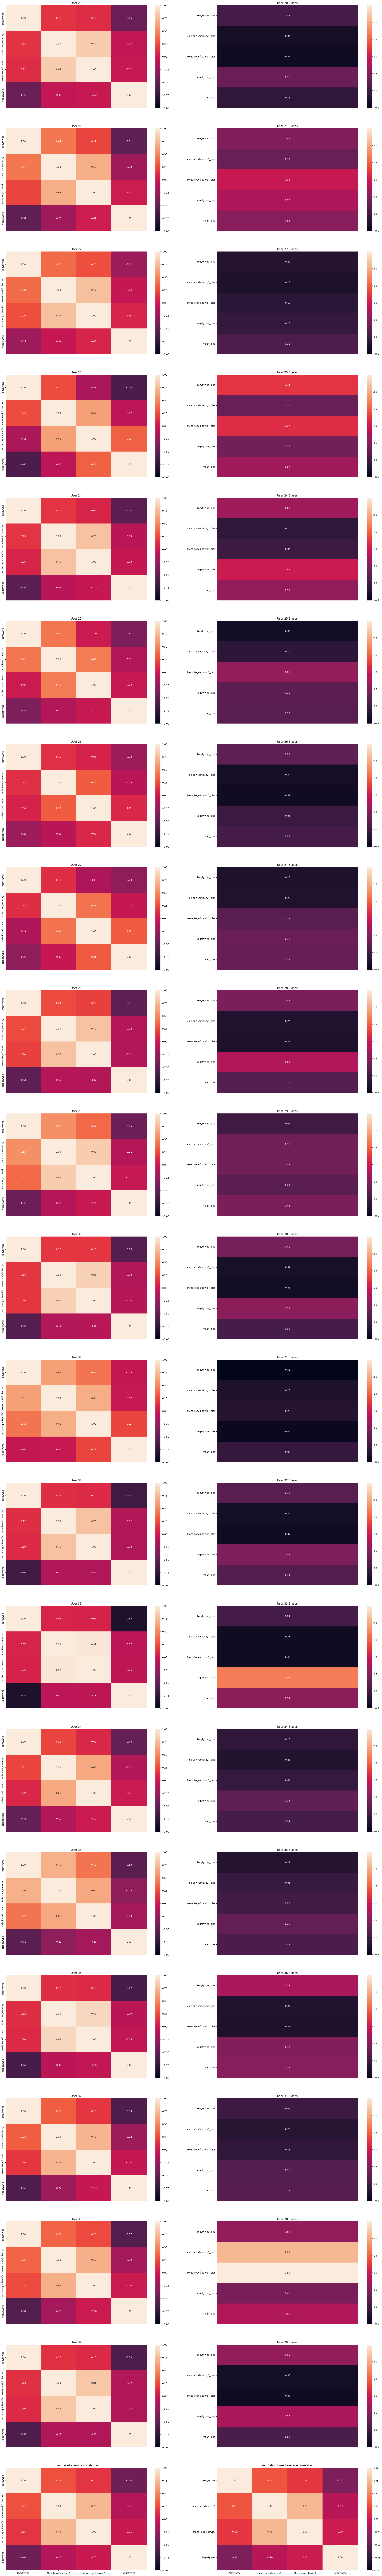

In [10]:
# humor-related user bias columns
bias_columns = ['Pozytywne_bias', 'Mnie bawi/śmieszy?_bias', 'Może kogoś bawić?_bias', 'Negatywne_bias', 'mean_bias']

# humor-related annotations columns
annotations_columns = ['Pozytywne', 'Mnie bawi/śmieszy?', 'Może kogoś bawić?', 'Negatywne']

# users ommited during creation of user-aggregated heatmap
not_aggregated_users = []

# copy Dataframe from previously downloaded file
df = annotations_df.copy()

# leave only those text, where at least one annotation for each task is not a zero
avg_df = df.groupby('text_id').mean(numeric_only=True)
nonzero_avg_texts = avg_df[(avg_df[annotations_columns] > 0).all(axis=1)].index.tolist()
df = df[df['text_id'].isin(nonzero_avg_texts)]

# create new dataframe with specific columns
task_df = df[annotations_columns]
df_list = [df[df['user_id'] == user_id][annotations_columns] for user_id in range(40)]
corr_list = [df.corr() for df in df_list]

# create list with user bias values
user_bias_list = [np.asarray(user_bias_df[user_bias_df['user_id'] == user_id][bias_columns].values.tolist()).reshape(-1, 1) for user_id in range(40)]

vmin = min(corr.values.min() for corr in corr_list)
vmax = max(corr.values.max() for corr in corr_list)

fig, axs = plt.subplots(ncols=2, nrows=21, figsize=(30, 200))
        
for row_idx in range(21):
        for col_idx in range(2):
                yticklabels = bias_columns if col_idx == 1 and row_idx < 20 else corr_list[0].columns
                # cbar = col_idx == 1
                cbar = True

                if row_idx < 20:
                        if col_idx == 0:
                                # calculate the correlation matrix
                                vmin = -1
                                vmax = 1
                                corr = corr_list[20+row_idx]
                                xticklabels = False
                                axs[row_idx, col_idx].set_title(f'User {20+row_idx}')
                        if col_idx == 1:
                                # get user bias values
                                # corr = np.asarray(user_bias_df[user_bias_df['user_id'] == row_idx][bias_columns].values).reshape(-1, 1)
                                corr = user_bias_list[20+row_idx]
                                vmin = min(min(bias_list) for bias_list in user_bias_list)
                                vmax = max(max(bias_list) for bias_list in user_bias_list)
                                # print(corr)
                                xticklabels = False 
                                axs[row_idx, col_idx].set_title(f'User {20+row_idx} Biases')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                elif row_idx == 20:
                        xticklabels = annotations_columns
                        vmin = -1
                        vmax = 1
                        if col_idx == 0:
                                # calculate user-grouped average correlation matrix
                                corr_list_temp = [df_corr for i, df_corr in enumerate(corr_list) if i not in not_aggregated_users]
                                corr = sum(corr_list_temp) / len(corr_list_temp)
                                axs[row_idx, col_idx].set_title('User-based average correlation')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                        elif col_idx == 1:
                                # calculate general average correlation matrix
                                corr = task_df.corr()
                                axs[row_idx, col_idx].set_title('Annotation-based average correlation')
                                axs[row_idx, col_idx].tick_params(axis='x', rotation=0)

                sns.heatmap(corr, 
                        annot=True, 
                        ax=axs[row_idx, col_idx], 
                        xticklabels=xticklabels, 
                        yticklabels=yticklabels,
                        cbar=cbar,
                        vmin=vmin,
                        vmax=vmax,
                        fmt='.2f')   
                             
plt.yticks(rotation=0)

if not os.path.exists(visualizations_dir):
    os.mkdir(visualizations_dir)

plt.savefig(visualizations_dir / 'doccano_text_corr_questionnaire_users_humor_polar_20_39.pdf', dpi=300)